### 载入必要的库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### 载入数据

!! 需要一键下载数据的脚本

In [17]:
data = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id','item_id','rating','timestamp'])
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id      100000 non-null int64
item_id      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [19]:
data.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [20]:
print('共 {} 位用户与 {} 部电影'.format(data.user_id.nunique(), data.item_id.nunique()))

共 943 位用户与 1682 部电影


# 数据的README

### 对user和rating聚合

In [21]:
item_user_count = data.groupby('item_id').count().user_id

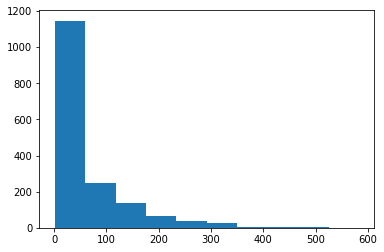

In [22]:
plt.hist(item_user_count.values)
plt.show()

In [23]:
item_user_count[item_user_count>20].shape

(927,)

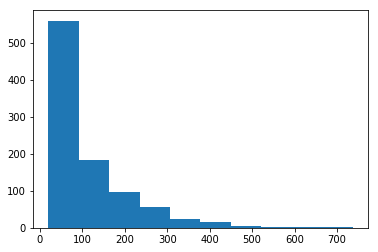

In [24]:
user_item_count = data.groupby('user_id').count().item_id
plt.hist(user_item_count.values)
plt.show()

In [25]:
user_item_count.describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: item_id, dtype: float64

### 生成user_item_rating矩阵
评分的基础上进行协同过滤,这东西....我感觉就是求一个相关性而已

In [26]:
r_user = data.user_id.nunique()
c_item = data.item_id.nunique()

user_item_matrix = np.zeros((r_user, c_item))
for index, user, item, rating, timestamp in data.itertuples():
    user_item_matrix[user-1, item-1] = rating

In [27]:
user_item_matrix[:10, :10]

array([[5., 3., 4., 3., 3., 5., 4., 1., 5., 3.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 2., 4., 4., 0.],
       [0., 0., 0., 5., 0., 0., 5., 5., 5., 4.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 4., 0., 0., 0.],
       [4., 0., 0., 4., 0., 0., 4., 0., 4., 0.]])

In [28]:
from sklearn.metrics.pairwise import pairwise_distances

In [29]:
item_similarity_m = pairwise_distances(user_item_matrix.T, metric='cosine')
item_similarity_m_triu = np.triu(item_similarity_m,k=1) # 取得上三角数据
item_sim_nonzero = np.round(item_similarity_m_triu[item_similarity_m_triu.nonzero()],3)
np.percentile(item_sim_nonzero,np.arange(0,101,10))

array([0.   , 0.776, 0.847, 0.889, 0.92 , 0.945, 0.97 , 1.   , 1.   ,
       1.   , 1.   ])

### 协同过滤

In [30]:
# 导入数据
data=pd.read_csv('ml-100k/u.data',sep='\t',names=['user_id','item_id','rating','timestamp'])
# 用户物品统计
r_users = data.user_id.nunique()
c_items = data.item_id.nunique()
# 拆分数据集
from sklearn.model_selection import train_test_split
train_data,test_data =train_test_split(data,test_size=0.2) #按照训练集70%，测试集30%的比例对数据进行拆分
# 训练集 用户-物品 矩阵
user_item_matrix = np.zeros((r_users,c_items))
for index, user, item, rating, timestamp in data.itertuples():
    user_item_matrix[user-1, item-1] = rating
    
    
train_data_matrix = np.zeros((r_users,c_items))
for index, user, item, rating, timestamp in train_data.itertuples():
    train_data_matrix[user-1, item-1] = rating
    
test_data_matrix = np.zeros((r_users, c_items))
for index, user, item, rating, timestamp in test_data.itertuples():
    test_data_matrix[user-1, item-1] = rating
    
    
# 构建物品相似矩阵 - 使用sklearn.metrics.pairwise中的cosine计算余弦距离
'''
采用余弦距离计算相似度
如果两个物品在同一条水平线上，则其夹角为零，对应的余弦值为1，代表完全相似
如果两个物品处于垂直的方向上，其夹角为90度，那么其余弦值为0，代表毫不相干
'''
from sklearn.metrics.pairwise import pairwise_distances
# 相似度计算定义为余弦距离
user_similarity = pairwise_distances(user_item_matrix, metric='cosine')
item_similarity = pairwise_distances(user_item_matrix.T,metric='cosine')
# 物品相似矩阵探索

def predict(rating, similarity, t='user'):
    if 'user' == t:
        mean_user_rating = rating.mean(axis = 1)
        rating_diff = (rating - mean_user_rating[:,np.newaxis])
        pred = mean_user_rating[:,np.newaxis] + similarity.dot(rating_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    else:
        pred = rating.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [31]:
item_prediction = predict(train_data_matrix, item_similarity, t = 'item')
user_prediction = predict(train_data_matrix, user_similarity, t = 'user')

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))


1. 通过改变物品矩阵相似度（采用欧式距离）的计算方法可以看出预测效果略有提升；
2. 通过增加训练集的方法对预测结果略有提升，但并不明显；
3. 在增加训练集的同时采用欧式距离计算相似度发现预测效果提升最好，但均方根误差依然很大，与之前预测（物品是分位数查看结果，其区分性并不是很好）相符；
4. 因而在此例中使用基于item的协同过滤推荐系统并不理想

In [33]:
'User based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix))

'User based CF RMSE: 3.111524306406056'

In [34]:
'Item based CF RMSe: ' + str(rmse(item_prediction, test_data_matrix))

'Item based CF RMSe: 3.457345185325297'

### SVD分解

In [35]:
import scipy.sparse as sp

from scipy.sparse.linalg import svds

u, s, vt = svds(train_data_matrix, k = 20)

s_diag_matrix = np.diag(s)

x_pred = np.dot(np.dot(u,s_diag_matrix),vt)

'User-based CF MSE: ' + str(rmse(x_pred, test_data_matrix))


'User-based CF MSE: 2.644744009215966'

### User数据

In [117]:
u_data = pd.read_csv('ml-100k/u.user', sep='|',names=['user_id', 'age', 'gender', 'occupation','code'])
u_data.head()

,user_id,age,gender,occupation,code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [118]:
u_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
user_id       943 non-null int64
age           943 non-null int64
gender        943 non-null object
occupation    943 non-null object
code          943 non-null object
dtypes: int64(2), object(3)
memory usage: 36.9+ KB


In [119]:
u_data['gender_num'] = u_data.gender.apply(lambda x: 1 if 'M' == x else 0)
u_X = u_data[['age', 'gender_num']]
u_label = u_data[['user_id', 'age', 'gender_num']]

In [120]:
u_data.occupation.nunique()

21

对occupation进行处理，这里暂时使用one_hot，考虑到直接labelencode会默认一个距离关系，所以先用one_hot,之后可以试验不用的效果

In [121]:
label = pd.get_dummies(u_data[['occupation']])

In [122]:
label.head()

,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,occupation_healthcare,occupation_homemaker,occupation_lawyer,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [123]:
user_personal_msg = pd.concat([u_label, label], axis=1)
user_personal_msg.head()

,user_id,age,gender_num,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,53,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,23,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,33,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [124]:
from sklearn.cluster import KMeans
pre_label = KMeans(n_clusters= 6, random_state=9).fit_predict(user_personal_msg)
user_personal_msg['label'] = pre_label
user_personal_msg.head()

,user_id,age,gender_num,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,label
0,1,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,53,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,23,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,33,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [125]:
user_personal_msg.to_csv('user_personal_label.csv', sep='\t', index=False)

### item数据

In [135]:
i_data = pd.read_csv('ml-100k/u.item', sep='|', names=['item_id', 'title', 'date', 'v_date', 'URL', 'Other', 'Action', 'Adventure', 'Animation', 'Children', 
                                                       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 
                                                       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],encoding='ISO-8859-1')
i_data.head()

,item_id,title,date,v_date,URL,Other,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [136]:
i_data.drop(columns=['v_date'], inplace=True)
i_data.dropna(how='any', inplace=True)
i_data.shape

(1679, 23)

In [137]:
movie_labels = i_data.drop(columns=['title', 'date', 'URL'])

In [138]:
y_pred = KMeans(n_clusters=6, random_state=9).fit_predict(movie_labels)
label = pd.DataFrame(y_pred, columns=['label'])
movie_labels = pd.concat([movie_labels, label], axis=1)

In [139]:
movie_labels.to_csv('item_label.csv', sep='\t', index=False)

电影年份这个数据是否进行使用,对数据处理来说应该有影响,但对这个系统完成来说,可以暂不考虑

In [140]:
i_data['year'] = i_data.date.apply(lambda x: x.split('-')[-1])
i_data = i_data.drop(columns=['date'])

In [141]:
i_data.head()

,item_id,title,URL,Other,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1995


In [227]:
item_msg = i_data[['item_id', 'title', 'URL']]
item_msg.to_csv('item_msg.csv', sep='\t')

### user&item
合并生成user偏好标签表, 用于冷启动时分类

In [46]:
user_and_item = data[['user_id', 'item_id', 'rating']]
i_label = i_data[['item_id', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'year']]

In [42]:
test= pd.concat([user_and_item, X, u_X], axis=1)
test = test.dropna(how='any')
test = test.astype(np.int)
test.shape

(942, 24)

In [56]:
_ = pd.merge(u_label, user_and_item, how='left', left_on='user_id', right_on='user_id')
_ = pd.merge(_, i_label, how='left', left_on='item_id', right_on='item_id')
_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 24 columns):
user_id        100000 non-null int64
age            100000 non-null int64
gender_num     100000 non-null int64
item_id        100000 non-null int64
rating         100000 non-null int64
Action         99987 non-null float64
Adventure      99987 non-null float64
Animation      99987 non-null float64
Children       99987 non-null float64
Comedy         99987 non-null float64
Crime          99987 non-null float64
Documentary    99987 non-null float64
Drama          99987 non-null float64
Fantasy        99987 non-null float64
Film-Noir      99987 non-null float64
Horror         99987 non-null float64
Musical        99987 non-null float64
Mystery        99987 non-null float64
Romance        99987 non-null float64
Sci-Fi         99987 non-null float64
Thriller       99987 non-null float64
War            99987 non-null float64
Western        99987 non-null float64
year           99987 

In [57]:
user_interst = _.dropna(how='any')
user_interst = user_interst.astype(np.int)
user_interst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99987 entries, 0 to 99999
Data columns (total 24 columns):
user_id        99987 non-null int64
age            99987 non-null int64
gender_num     99987 non-null int64
item_id        99987 non-null int64
rating         99987 non-null int64
Action         99987 non-null int64
Adventure      99987 non-null int64
Animation      99987 non-null int64
Children       99987 non-null int64
Comedy         99987 non-null int64
Crime          99987 non-null int64
Documentary    99987 non-null int64
Drama          99987 non-null int64
Fantasy        99987 non-null int64
Film-Noir      99987 non-null int64
Horror         99987 non-null int64
Musical        99987 non-null int64
Mystery        99987 non-null int64
Romance        99987 non-null int64
Sci-Fi         99987 non-null int64
Thriller       99987 non-null int64
War            99987 non-null int64
Western        99987 non-null int64
year           99987 non-null int64
dtypes: int64(24)
memory us

In [59]:
user_interst.to_csv('user_interst.csv', sep='\t', index=False)

### user_item表
建立user看过的电影表, 直接使用最开始的user_rating即可,不为零的就是看过的

### 建模

#### 冷启动
初次使用获取用户电影偏好的标签和用户基础信息和看过的电影,这里的偏好标签和电影均在数据库中存在对应值,然后分类进行推荐

In [ ]:
def c_start():
    

### 用户使用过程中的动态优化
这部分使用协同过滤矩阵,对用户的使用进行收集信息,对某部电影的搜索/点击/评分等操作都转化成对应权重进行返回,更新协同过滤矩阵,动态更新推荐内容

In [ ]:
def matrix_update():
    

### 用户信息处理

In [103]:
user_msg = pd.read_csv('user_interst.csv', sep='\t')
user_msg.head()

,user_id,age,gender_num,item_id,rating,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,24,1,61,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1994
1,1,24,1,189,3,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1992
2,1,24,1,33,4,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1995
3,1,24,1,160,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1992
4,1,24,1,20,4,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1995


In [104]:
user_msg.drop(columns=['age', 'age', 'gender_num', 'item_id', 'rating', 'year'], inplace=True)
groupby = user_msg.groupby(by='user_id')

In [105]:
group_sum = groupby.sum(axis=1)

In [106]:
group_sum.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,
1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6
2,10,3,1,4,16,9,0,35,1,2,2,1,4,16,4,12,3,0
3,14,4,0,0,12,10,1,22,0,2,5,2,11,5,8,21,5,0
4,8,4,0,0,4,4,1,6,0,0,1,1,5,3,6,11,2,0
5,56,33,14,29,82,9,0,27,2,1,28,12,3,19,33,19,14,2


这里对用户偏好标签进行比例划分,偏好系数 = $\frac{标签次数}{总计标签数}$,当用户更新标签时,也对应更新系数即可

In [107]:
total_labels = group_sum.apply(lambda x: x.sum(), axis=1)

In [108]:
user_item_labels = group_sum.values / total_labels.values.reshape(-1, 1)

In [109]:
user_item_labels = pd.DataFrame(user_item_labels, columns=group_sum.columns)

In [110]:
user_item_labels.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.127986,0.071672,0.020478,0.042662,0.155290,0.042662,0.008532,0.182594,0.003413,0.001706,0.022184,0.022184,0.008532,0.075085,0.073379,0.088737,0.042662,0.010239
1,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000
2,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000
3,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000
4,0.146214,0.086162,0.036554,0.075718,0.214099,0.023499,0.000000,0.070496,0.005222,0.002611,0.073107,0.031332,0.007833,0.049608,0.086162,0.049608,0.036554,0.005222


In [111]:
y_pred = KMeans(n_clusters=18, random_state=9).fit_predict(user_item_labels)

In [112]:
label = pd.DataFrame(y_pred, columns=['label'])
user_id = pd.DataFrame(group_sum.index)
user_item_labels = pd.concat([user_id, user_item_labels, label], axis=1)

In [115]:
user_item_labels.head()

,user_id,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,label
0,1,0.127986,0.071672,0.020478,0.042662,0.155290,0.042662,0.008532,0.182594,0.003413,0.001706,0.022184,0.022184,0.008532,0.075085,0.073379,0.088737,0.042662,0.010239,6
1,2,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000,3
2,3,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000,16
3,4,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000,13
4,5,0.146214,0.086162,0.036554,0.075718,0.214099,0.023499,0.000000,0.070496,0.005222,0.002611,0.073107,0.031332,0.007833,0.049608,0.086162,0.049608,0.036554,0.005222,1


In [116]:
user_item_labels.to_csv('user_item_label.csv', sep='\t', index=False)

聚类部分完成

### 分类与推荐

In [146]:
import xgboost as xgb

In [145]:
from sklearn.model_selection import train_test_split
train_data,test_data =train_test_split(user_item_labels, test_size=0.2)

In [159]:
dtrain = xgb.DMatrix(train_data.iloc[:, 1:-1], label=train_data.iloc[:, -1])
dtest = xgb.DMatrix(test_data.iloc[:, 1:-1], label=test_data.iloc[:, -1])

In [161]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 18,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 8,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.1,                  # 如同学习率
    'seed': 1000,
    'nthread': 8,                  # cpu 线程数
}

In [168]:
num_round = 10
evallist  = [(dtest,'eval'), (dtrain,'train')]
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_round, evals=evallist)

[0]	eval-merror:0.465608	train-merror:0.374005
[1]	eval-merror:0.460317	train-merror:0.27321
[2]	eval-merror:0.343915	train-merror:0.208223
[3]	eval-merror:0.333333	train-merror:0.171088
[4]	eval-merror:0.312169	train-merror:0.132626
[5]	eval-merror:0.306878	train-merror:0.122016
[6]	eval-merror:0.285714	train-merror:0.114058
[7]	eval-merror:0.259259	train-merror:0.102122
[8]	eval-merror:0.243386	train-merror:0.096817
[9]	eval-merror:0.238095	train-merror:0.096817


In [169]:
bst.save_model('user_item.model')